# Seguridad Vial

In [1]:
import pandas as pd
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
import geopandas as gpd

In [5]:
import contextily as cx

In [6]:
from pyproj import Proj, transform

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.set_option('display.max_columns', None)

## Cargando datos

In [9]:
df = pd.read_csv('data/external/siniestros_individuales_conaset/individuales_biobio_2020.csv')

In [10]:
df.sample()

,X,Y,FID,COD_REG,REGION,CUT,COMUNA,CALLE_UNO,CALLE_DOS,NUMERO,DIR_GEOCOD,LAT,LNG,VAL_COM,TIPO,Año,Idaccident,Fecha,Tipo_Accid,Tipo__CONA,Zona,Causa__CON,Causa,Fallecidos,Graves,Menos_Grav,Leves,Hora
481,-73.114699,-36.768764,482,8,REGION BIO BIO,8110,TALCAHUANO,GRAN BRETAÑA,,4889,"Gran Bretaña 4889, Talcahuano, Bío Bío, Chile",-36.768764,-73.114699,1,ROOFTOP,2020,1305782,2020/10/17 00:00:00+00,VOLCADURA,VOLCADURA,URBANA,PERDIDA CONTROL VEHICULO,PERDIDA CONTROL VEHICULO,0,0,0,1,19:00:00


In [11]:
df.shape

(4482, 28)

Seleccionando variables

In [12]:
df = df[['LNG','LAT','FID','Fecha','Hora','CALLE_UNO','CALLE_DOS', 'NUMERO', 'COMUNA', 'COD_REG']]

Creando variables nuevas

In [13]:
df.rename(columns = {'LNG':'Longitude', 'LAT':'Latitude'}, inplace = True)

In [14]:
df['Fecha'] = df['Fecha'].apply(lambda x: x[:10])
df['fecha_hora'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora']) 

In [15]:
df['dow'] = df['fecha_hora'].dt.dayofweek

In [16]:
df['hour'] = df['fecha_hora'].dt.hour

Longitud y latitud

In [17]:
df['Longitude'], df['Latitude'] = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), df.Longitude, df.Latitude)  # longitude first, latitude second.

In [18]:
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude, crs = "EPSG:3857"))

## Mapa de Chile

In [19]:
chile = gpd.read_file('data/internal/comunas/comunas.shp')

In [20]:
chile.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Calles

In [21]:
calles = gpd.read_file('data/external/maestro_calles_2018/MAESTRO_EJES.shp')

## Graficos

In [22]:
heatmap_accidentes = pd.pivot_table(values = 'FID', index = 'hour', columns = 'dow', aggfunc = 'count', data = df[df['COMUNA']=='CONCEPCION'])
heatmap_accidentes.fillna(0, inplace = True)

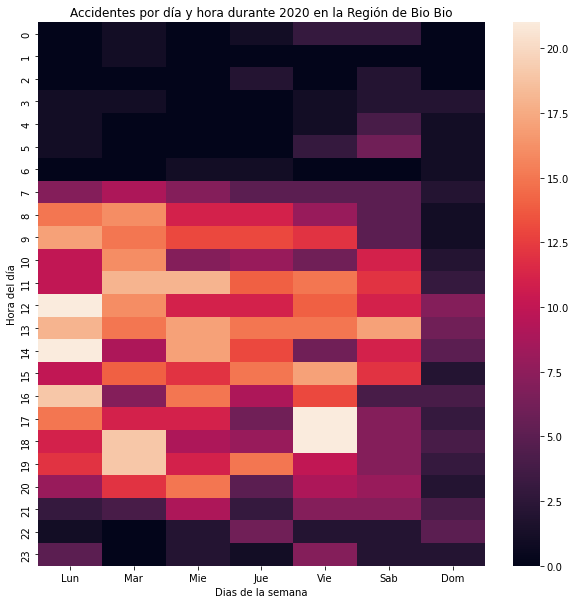

In [23]:
fig, ax = plt.subplots(1,1,figsize = (10, 10))
s = sns.heatmap(heatmap_accidentes, xticklabels=['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'], ax = ax)
s.set(xlabel='Dias de la semana', ylabel='Hora del día')
s.set_title('Accidentes por día y hora durante 2020 en la Región de Bio Bio');

## Mapas

In [25]:
df_wm = chile[(chile['codregion']==8) & (chile['Comuna'].isin(['TALCAHUANO','CONCEPCION']))]

(-8140000.0, -8125000.0)

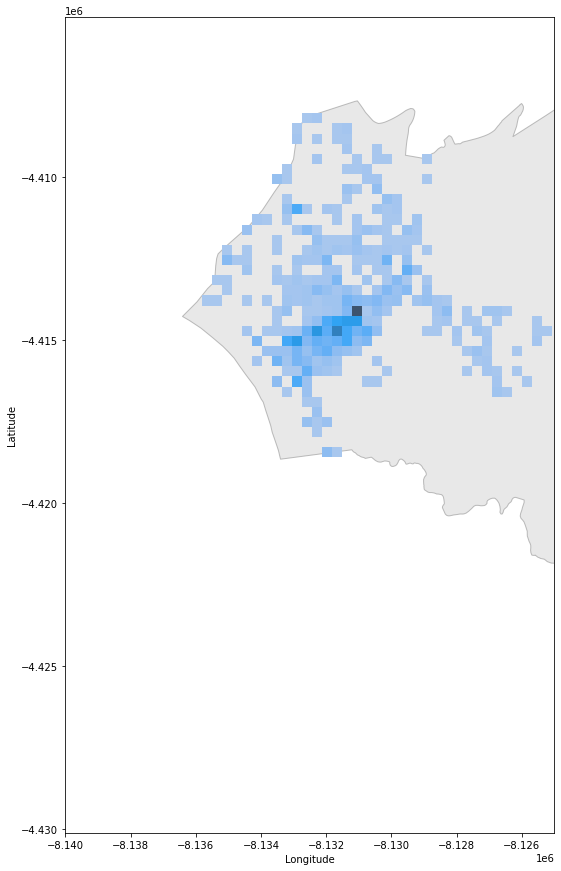

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
df_wm.plot(
    color = 'lightgray',
    edgecolor="gray",
    alpha = 0.5,
    ax = ax
)



sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    kde = True,
    ax = ax,
    data = df[df['COMUNA']=='CONCEPCION']
)

ax.set_xlim([-8.14E6,-8.125E6])
#ax.set_ylim([-4.05E6,-4.225E6])

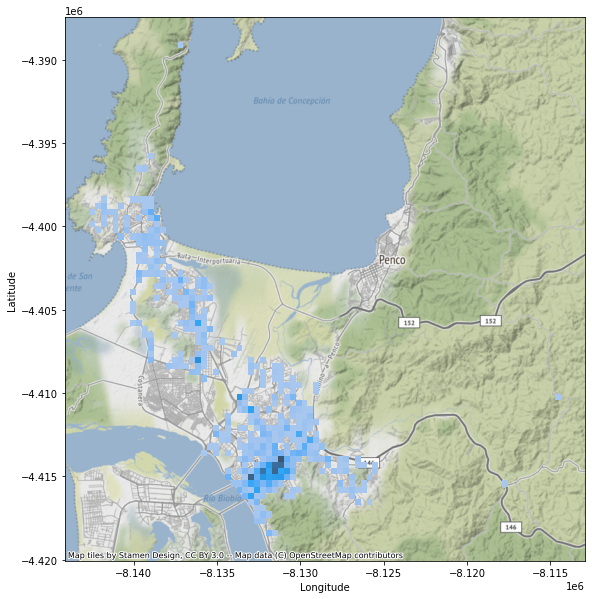

In [67]:
df_wm = chile[(chile['codregion']==8) & (chile['Comuna'].isin(['TALCAHUANO','CONCEPCION']))]

ax = df_wm.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')


sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    kde = True,
    bins = 50,
    ax = ax,
    data = df[df['COMUNA'].isin(['TALCAHUANO','CONCEPCION'])]
)

cx.add_basemap(ax)

In [72]:
chile

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735...."
342,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320...."
343,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933...."
344,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309...."


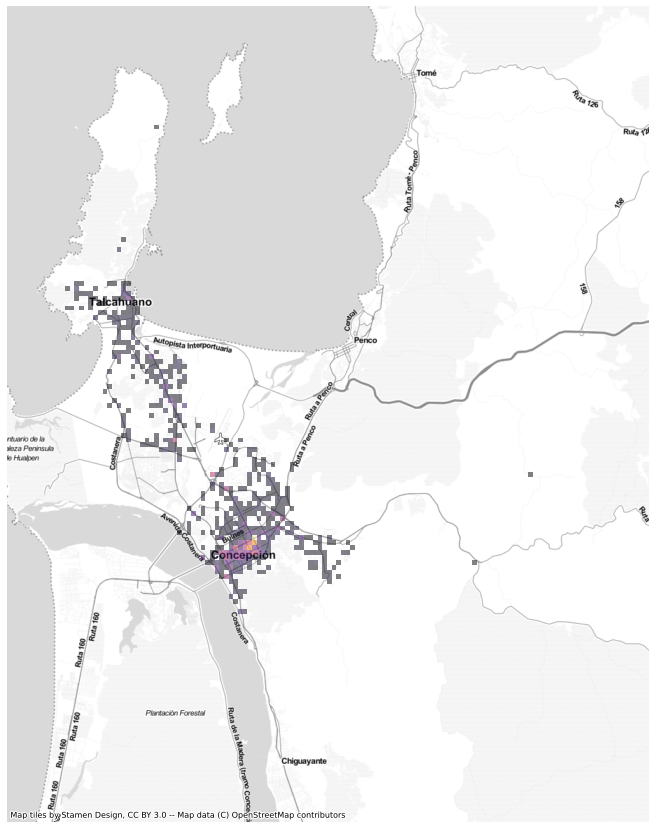

In [82]:
df_wm = chile[(chile['Comuna'].isin(['Concepción','Talcahuano']))]

ax = df_wm.plot(figsize=(15, 15), alpha=0, edgecolor='k')

sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    element = 'poly',
    bins = 100, 
    kde = True,
    alpha = 0.5,
    cmap = 'inferno',
    ax = ax,
    data = df[df['COMUNA'].isin(['TALCAHUANO','CONCEPCION'])] 
)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

plt.savefig('concepcion.jpg')